# Model-based feature importance

[Reference](https://towardsdatascience.com/model-based-feature-importance-d4f6fb2ad403)

[Dataset](https://archive.ics.uci.edu/ml/datasets/Glass+Identification)

In [1]:
DATA_DIR = './data/glass/'

In [2]:
import pandas as pd
import numpy as np
import os

from pylab import rcParams
rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [3]:
columns = ['RI', 'Na', 'Mg', 'Al', 'Si', 
           'K', 'Ca', 'Ba', 'Fe', 'class']
df_glass = pd.read_csv(os.path.join(DATA_DIR, 'glass.data'),
                      header=None,
                      names=columns)
print(df_glass.shape)
df_glass.head()

(214, 10)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


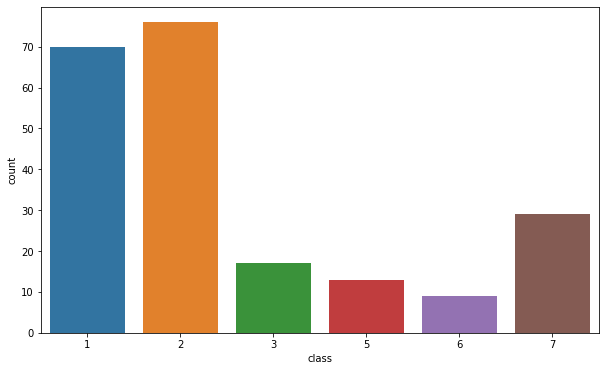

In [4]:
sns.countplot(x = 'class', data=df_glass)

In [117]:
df_small = df_glass.loc[df_glass['class'] < 3]
df_small.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [118]:
[print(x) for x in df_small['class'].unique()]
print()

1
2



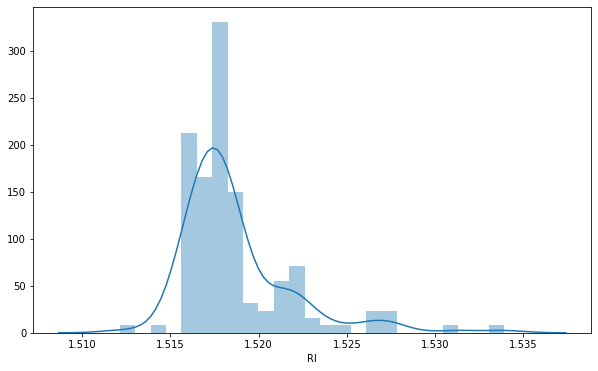

In [119]:
sns.distplot(df_small['RI'])

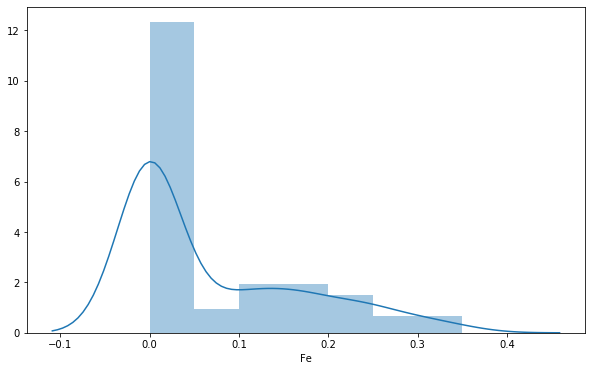

In [120]:
sns.distplot(df_small['Fe'])

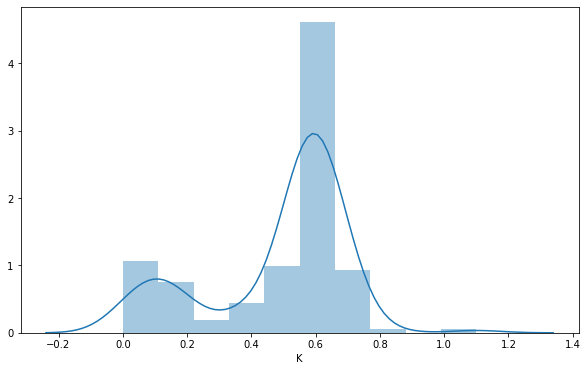

In [121]:
sns.distplot(df_small['K'], bins = 10)

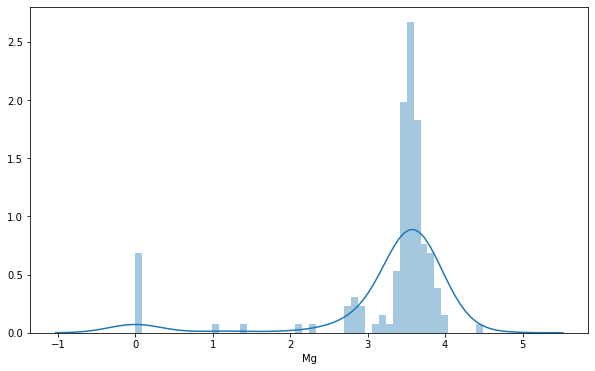

In [122]:
sns.distplot(df_small['Mg'])

In [123]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

import sklearn
sklearn.__version__

'0.22.1'

In [157]:
x_train, x_test, y_train, y_test = train_test_split(df_small.drop(['class'], axis = 1), 
                                                    df_small['class'], 
                                                    stratify=df_small['class'])

In [158]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [159]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [160]:
solver = 'saga'

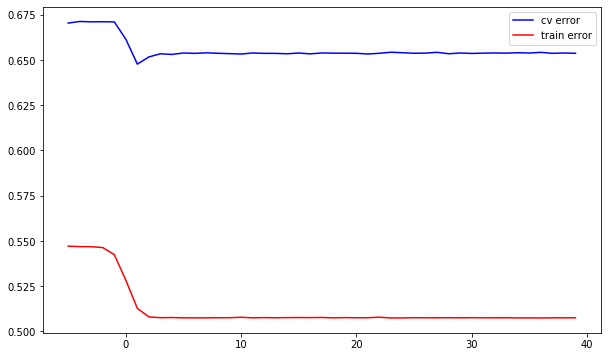

In [161]:
alpha = [10**x for x in np.arange(-5, 40, dtype=float)]
log_alpha = np.arange(-5, 40)

cv_err = []
train_err = []

for a in alpha:
    clf = LogisticRegression(C=a, 
                             penalty='l2', 
                             class_weight='balanced',
                             solver=solver)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf)
    sig_clf.fit(x_train, y_train)
    
    predict_y = sig_clf.predict_proba(x_test)
    cv_err.append(log_loss(y_test, predict_y))
    
    predict_y = sig_clf.predict_proba(x_train)
    train_err.append(log_loss(y_train, predict_y))
    
plt.plot(log_alpha, cv_err, label='cv error', c='b')
plt.plot(log_alpha, train_err, label='train error', c='r')
plt.legend()
plt.show()

In [162]:
alpha[np.argmin(cv_err)]

10.0

In [163]:
np.min(cv_err)

0.6477271416428987

In [164]:
from sklearn.metrics import accuracy_score

In [165]:
accuracy_score(y_test, clf.predict(x_test))

0.5405405405405406

In [166]:
clf=LogisticRegression(C=alpha[np.argmin(cv_err)], 
                       penalty='l2', 
                       class_weight='balanced',
                       solver=solver)
clf.fit(x_train, y_train)

LogisticRegression(C=10.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [167]:
clf.coef_.T

array([[-0.08528918],
       [ 0.49897101],
       [-4.91029984],
       [ 6.02016652],
       [ 0.08325879],
       [ 0.76201793],
       [ 0.00850937],
       [-0.50594546],
       [ 1.08499919]])

In [168]:
np.array([columns[:-1]]).T

array([['RI'],
       ['Na'],
       ['Mg'],
       ['Al'],
       ['Si'],
       ['K'],
       ['Ca'],
       ['Ba'],
       ['Fe']], dtype='<U2')

In [169]:
feature_importance=pd.DataFrame(np.hstack((np.array([columns[:-1]]).T, clf.coef_.T)), columns=['feature', 'importance'])

In [170]:
feature_importance['importance']=pd.to_numeric(feature_importance['importance'])

In [171]:
feature_importance.sort_values('importance', ascending=False)

,feature,importance
3,Al,6.020167
8,Fe,1.084999
5,K,0.762018
1,Na,0.498971
4,Si,0.083259
6,Ca,0.008509
0,RI,-0.085289
7,Ba,-0.505945
2,Mg,-4.910300
